In [118]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from spellchecker import SpellChecker
spell = SpellChecker()
sns.set(font_scale=3)
from sklearn.model_selection import KFold
from sklearn import datasets, linear_model, metrics 
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
import altair as alt
alt.data_transformers.enable('csv')
alt.renderers.enable('notebook')


pd.set_option("display.max_columns", 200)
pd.options.display.max_rows = 100
use_cache = True

In [2]:
lc = pd.read_csv("~/Projects/dsa601/data/lendingclub_2014_ng.csv")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (15,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
lc = lc
lc['default'] = 0
lc.loc[lc['loan_status'] == 'Charged Off', 'default'] = 1

In [4]:
i = 0

def fix_spelling(words):
    global i
    i += 1
    if ((i % 100) == 0):
        print(i, datetime.now())
    words = words.split(' ')
    words = list(map(lambda word: spell.correction(word), words))
    return ' '.join(words)

In [5]:
lc["emp_title"] = lc["emp_title"].str.lower()
lc["emp_title"] = lc["emp_title"].str.strip()
lc['emp_title'].fillna("unknown", inplace = True)

In [6]:
lc = pd.read_csv("~/Projects/dsa601/data/lendingclub_2014_ng_spelling2.csv", index_col=0)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (16,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
tenth_percent_len = len(lc) * 0.001
counts = lc['title'].value_counts()
counts = counts[counts < tenth_percent_len]
dic = {}
for idx in counts.index:
    dic[idx] = 'other'

lc['title'] = lc['title'].replace(dic)

In [8]:
lc.drop(['id'],axis=1,inplace=True)
lc.drop(['desc'],axis=1,inplace=True)
lc['loan_amnt'].equals(lc['funded_amnt'])
lc.drop(['funded_amnt'],axis=1,inplace=True)

In [9]:
def convert_to_month(date_str):
    date_as_datetime = datetime.strptime(date_str, '%b-%d')
    return date_as_datetime.strftime('%B')

lc['issue_d'] = lc.issue_d.transform(convert_to_month)
def strip_percent(string):
    return str(string).strip('%')

lc.revol_util = lc.revol_util.transform(strip_percent).astype(float)

def fetch_month_from_month_year_format(date_str):
    date_as_datetime = datetime.strptime(date_str, '%b-%y')
    return date_as_datetime.strftime('%B')

def fetch_year_from_month_year_format(date_str):
    date_as_datetime = datetime.strptime(date_str, '%b-%y')
    return date_as_datetime.strftime('%Y')

# replace the na with the most common date
lc['last_pymnt_d'].fillna('Mar-17', inplace = True)
lc['last_credit_pull_d'].fillna('Nov-19', inplace = True)
lc['hardship_end_date'].fillna('Dec-17', inplace = True)
lc['hardship_start_date'].fillna('Sep-17', inplace = True)
lc['settlement_date'].fillna('Apr-17', inplace = True)

lc['earliest_cr_line_month'] = lc.earliest_cr_line.transform(fetch_month_from_month_year_format)
lc['earliest_cr_line_year'] = lc.earliest_cr_line.transform(fetch_year_from_month_year_format)
lc.drop(['earliest_cr_line'],axis=1,inplace=True)

lc['last_pymnt_d_month'] = lc.last_pymnt_d.transform(fetch_month_from_month_year_format)
lc['last_pymnt_d_year'] = lc.last_pymnt_d.transform(fetch_year_from_month_year_format)
lc.drop(['last_pymnt_d'],axis=1,inplace=True)

lc['last_credit_pull_d_month'] = lc.last_credit_pull_d.transform(fetch_month_from_month_year_format)
lc['last_credit_pull_d_year'] = lc.last_credit_pull_d.transform(fetch_year_from_month_year_format)
lc.drop(['last_credit_pull_d'],axis=1,inplace=True)

lc['hardship_end_date_month'] = lc.hardship_end_date.transform(fetch_month_from_month_year_format)
lc['hardship_end_date_year'] = lc.hardship_end_date.transform(fetch_year_from_month_year_format)
lc.drop(['hardship_end_date'],axis=1,inplace=True)

lc['hardship_start_date_month'] = lc.hardship_start_date.transform(fetch_month_from_month_year_format)
lc['hardship_start_date_year'] = lc.hardship_start_date.transform(fetch_year_from_month_year_format)
lc.drop(['hardship_start_date'],axis=1,inplace=True)

lc['settlement_date_month'] = lc.settlement_date.transform(fetch_month_from_month_year_format)
lc['settlement_date_year'] = lc.settlement_date.transform(fetch_year_from_month_year_format)
lc.drop(['settlement_date'],axis=1,inplace=True)

In [10]:
lc = lc
lc['default'] = 0
lc.loc[lc['loan_status'] == 'Charged Off', 'default'] = 1

In [11]:
null_percent = np.sum(lc.isnull()) *100/len(lc)

null_100 = list(null_percent[null_percent == 100].sort_index().index)
null_95 = list(null_percent[(null_percent != 100) & (null_percent >= 95)].sort_index().index)
null_95_keep_set_hard = list(filter(lambda s: not s.startswith('settlement_') and not s.startswith('hardship_'), null_95))
null_75 = list(null_percent[(null_percent < 95) & (null_percent >= 75)].sort_index().index)

# Columns that 100% null have no value to us.
lc.drop(null_100,axis=1,inplace=True)
# Remove most columns that are null 95% of the time or more. Keep around the 'settlement' and 'hardship'
# since those columns should be rare events.
lc.drop(null_95_keep_set_hard,axis=1,inplace=True)
# There is only 1 column if we lower to 75% so I am just going to keep that in.

In [12]:
s = lc.isna().sum()
s[s > 0].sort_index()

avg_cur_bal                            6
bc_open_to_buy                      2445
bc_util                             2611
emp_length                         12017
hardship_amount                   235099
hardship_dpd                      235099
hardship_last_payment_amount      235099
hardship_length                   235099
hardship_loan_status              235099
hardship_payoff_balance_amount    235099
hardship_reason                   235099
hardship_status                   235099
hardship_type                     235099
mo_sin_old_il_acct                  7170
mths_since_last_delinq            115870
mths_since_last_major_derog       169134
mths_since_last_record            194086
mths_since_recent_bc                2246
mths_since_recent_bc_dlq          173334
mths_since_recent_inq              21690
mths_since_recent_revol_delinq    150852
num_tl_120dpd_2m                    7859
percent_bc_gt_75                    2557
revol_util                           125
settlement_amoun

In [13]:
def mean_by_default(independent_var, default):
    lc[independent_var] = lc[independent_var].astype(float)
    return lc.groupby(['default']).agg({independent_var : ['mean']})[independent_var].loc[default]['mean']

def fill_mean_by_default_group(independent_var):
    lc.loc[(lc['default'] == 0) & (lc[independent_var].isna()), independent_var] = mean_by_default(independent_var, 0)
    lc.loc[(lc['default'] == 1) & (lc[independent_var].isna()), independent_var] = mean_by_default(independent_var, 1)

In [14]:
v = 'hardship_payoff_balance_amount'
print(mean_by_default(v,0))
print(mean_by_default(v,1))
# fill_mean_by_default_group(v)
print(f'fill_mean_by_default_group("{v}")')

7502.630981132075
8624.414279835388
fill_mean_by_default_group("hardship_payoff_balance_amount")


In [15]:
# There are onlt 125 null records here, mean seemed safe.
fill_mean_by_default_group('avg_cur_bal')
# There are 2445 null records here, I am assuming that null means they have no open to by items.
lc['bc_open_to_buy'].fillna(0, inplace = True)
# There are 2611 null records here, this is the ratio of credit balance to credit limit.
fill_mean_by_default_group('bc_util')
# we might want to change this if we choose to convert this to int.
lc["emp_length"].fillna("0 years", inplace = True)

# There are 7170 records. This is the months since their last account, im assuming null means no such accounts existed.
lc['mo_sin_old_il_acct'].fillna(0, inplace = True)
# There are 115870 records. Going with the conditonal mean
fill_mean_by_default_group('mths_since_last_delinq')
# There are 169134 records. Going with the conditonal mean
fill_mean_by_default_group("mths_since_last_major_derog")
# There are 2246 records. I'm assuming they never had a backrupcy account.
fill_mean_by_default_group("mths_since_recent_bc")
#  There are 173334 records. I'm assuming they never had a delinquency account, so I put the max number in there.
fill_mean_by_default_group("mths_since_recent_bc_dlq")
#  There are 21690 records. I'm assuming null means they made an inquary this month
lc["mths_since_recent_inq"].fillna(0, inplace = True)
#  There are 150852 records. I'm assuming they never had a delinquency account, so I put the max number in there.
fill_mean_by_default_group("mths_since_recent_revol_delinq")
#  There are 7859 records. I'm assuming they had no accounts past due in the last 120 days.
lc["num_tl_120dpd_2m"].fillna(0, inplace = True)
#  There are 2557 records. I'm assuming they had no accounts that are greater than 75% of the limit.
lc["percent_bc_gt_75"].fillna(0, inplace = True)

#  There are 194086 records. I'm assuming they had no accounts that are greater than 75% of the limit.
fill_mean_by_default_group("mths_since_last_record")

# There are onlt 125 null records here, mean seemed safe.
fill_mean_by_default_group("revol_util")
# Assume there was no hardship for the null records. So I put zero for the amount.
lc['hardship_amount'].fillna(0, inplace = True)

# 235099 records
fill_mean_by_default_group("hardship_dpd")
# 235099 records
fill_mean_by_default_group("hardship_last_payment_amount")
#  There are 235099 records. I'm assuming they had no hardships
lc["hardship_length"].fillna(0, inplace = True)
#  There are 235099 records. I'm assuming they had no hardships
lc["hardship_payoff_balance_amount"].fillna(0, inplace = True)
#  There are 235099 records. I'm assuming they had no hardships
lc["hardship_loan_status"].fillna("NO_HARDSHIP", inplace = True)
#  There are 235099 records. I'm assuming they had no hardships
lc["hardship_status"].fillna("NO_HARDSHIP", inplace = True)
#  There are 235099 records. I'm assuming they had no hardships
lc["hardship_reason"].fillna("NO_HARDSHIP", inplace = True)
#  There are 235099 records. I'm assuming they had no hardships
lc["hardship_type"].fillna("NO_HARDSHIP", inplace = True)

#  There are 231106 records. I'm assuming they had no settlement
lc["settlement_amount"].fillna(0, inplace = True)
#  There are 231106 records. I'm assuming they had no settlement
lc["settlement_percentage"].fillna(0, inplace = True)
#  There are 231106 records. I'm assuming they had no settlement
lc["settlement_status"].fillna("NO_SETTLEMENT", inplace = True)
#  There are 231106 records. I'm assuming they had no settlement
lc["settlement_percentage"].fillna(0, inplace = True)
#  There are 231106 records. I'm assuming they had no settlement
lc["settlement_term"].fillna(0, inplace = True)

In [16]:
lc['monthly_inc'] =  lc['annual_inc'] / 12
lc['monthly_debt'] =  lc['monthly_inc'] * lc['dti'] * 0.01

lc['dti_including_lc'] = (lc['monthly_debt'] + lc['installment']) / lc['monthly_inc']
lc.drop(["monthly_inc", "monthly_debt"], axis=1, inplace=True)

In [17]:
corr_mat = lc.corr(method='pearson')
corr_pairs = corr_mat.abs().unstack().sort_values()
corr_pairs_over_90 = corr_pairs[corr_pairs != 1][corr_pairs >.90]
pd_corr_pairs_over_90 = lc[corr_pairs_over_90.index.map(lambda x: x[0]).to_numpy()]

In [18]:
unique_corr_pairs_over_90 = []
for index1, index2 in corr_pairs_over_90.index:
    if [index2, index1] not in unique_corr_pairs_over_90:
        if index1 != 'default' and index2 != 'default':
            unique_corr_pairs_over_90.append([index1, index2])

column_to_delete = []
for pair in unique_corr_pairs_over_90:
    pair.append('default')
    corr_mat = lc[pair].corr(method='pearson').abs()
    corr_mat.drop(["default"], inplace=True)
    corr_mat = corr_mat.sort_values(by=['default'])
    index1, index2 = corr_mat.index.to_numpy()
    padded_index1 = index1.ljust(30, ' ')
    padded_index2 = index2.ljust(30, ' ')
    corr_indexes = corr_mat[index1][index2]
    index1_corr_default = corr_mat.loc[index1].default
    index2_corr_default = corr_mat.loc[index2].default
    print(f'{corr_indexes} is the correlation between "{index1}" and "{index2}".')
    print(f'{padded_index1} correlation with default is: {index1_corr_default}')
    print(f'{padded_index2} correlation with default is: {index2_corr_default}')
    if index1_corr_default > index2_corr_default:
        print(f'We will delete {index2} because {index1} has a higher correlation with default.')
        column_to_delete.append(index2)
    else:
        print(f'We will delete {index1} because {index2} has a higher correlation with default.')
        column_to_delete.append(index1)
    print('\n')

lc.drop(list(set(column_to_delete)), axis=1, inplace=True)

0.9203531458405904 is the correlation between "dti" and "dti_including_lc".
dti                            correlation with default is: 0.09007900158041957
dti_including_lc               correlation with default is: 0.115034351241208
We will delete dti because dti_including_lc has a higher correlation with default.


0.9478636458495493 is the correlation between "installment" and "funded_amnt_inv".
installment                    correlation with default is: 0.022662037085275023
funded_amnt_inv                correlation with default is: 0.04103554208444288
We will delete installment because funded_amnt_inv has a higher correlation with default.


0.9478987669565179 is the correlation between "installment" and "loan_amnt".
installment                    correlation with default is: 0.022662037085275023
loan_amnt                      correlation with default is: 0.041025297157318896
We will delete installment because loan_amnt has a higher correlation with default.


0.9589641911606218 i

In [19]:
# We calculated our dependent variable directly with this.
lc.drop(['loan_status'], axis=1, inplace=True)
# Hardship happens after the loan defaults, so we know that loans with hardship have defaulted.
hardship_features = [col for col in lc.columns if 'hardship' in col]
lc.drop(hardship_features, axis=1, inplace=True)

# Settlement happens after the loan defaults, so we know that loans with hardship have defaulted.
settlement_features = [col for col in lc.columns if 'settlement' in col]
lc.drop(settlement_features, axis=1, inplace=True)

# We won't know info about their pyment before they make the loan.
lc.drop(['total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'last_pymnt_amnt', 'last_pymnt_d_month', 'last_pymnt_d_year'], axis=1, inplace=True)

# We won't know the newer pulled fico scores at time of giving out the loan
lc.drop(['last_fico_range_high', 'last_fico_range_low'], axis=1, inplace=True)

lc.drop(['recoveries'], axis=1, inplace=True)

In [20]:
unique_count = lc.nunique()
lc.drop(unique_count[unique_count == 1].index.to_numpy(), axis=1, inplace=True)

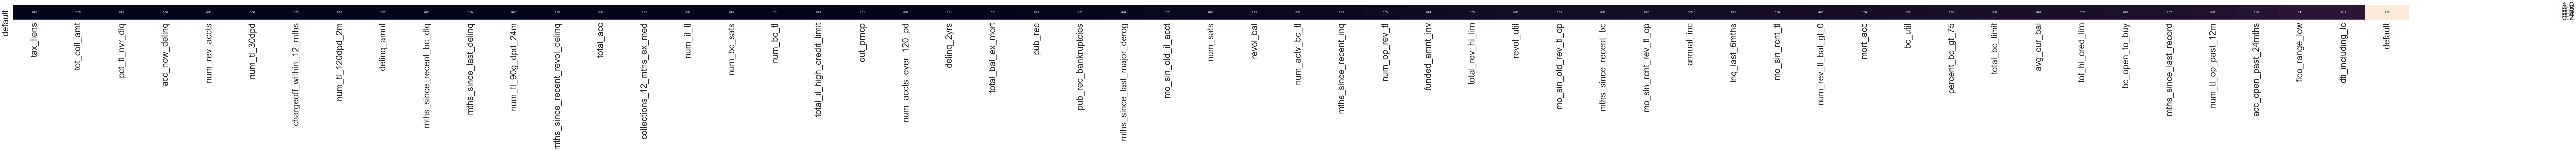

In [21]:
num = lc.select_dtypes(exclude = 'object')
numcorr = num.corr()
f, ax = plt.subplots(figsize = (200,1))
numcorr.sort_values(by = 'default', ascending = False).head(1)
corr_with_default = numcorr.sort_values(by = 'default', ascending = False).head(1)
corr_with_default = abs(corr_with_default).sort_values(by ='default', axis=1)
sns.heatmap(corr_with_default, annot = True, fmt=".2f")
plt.show()

''

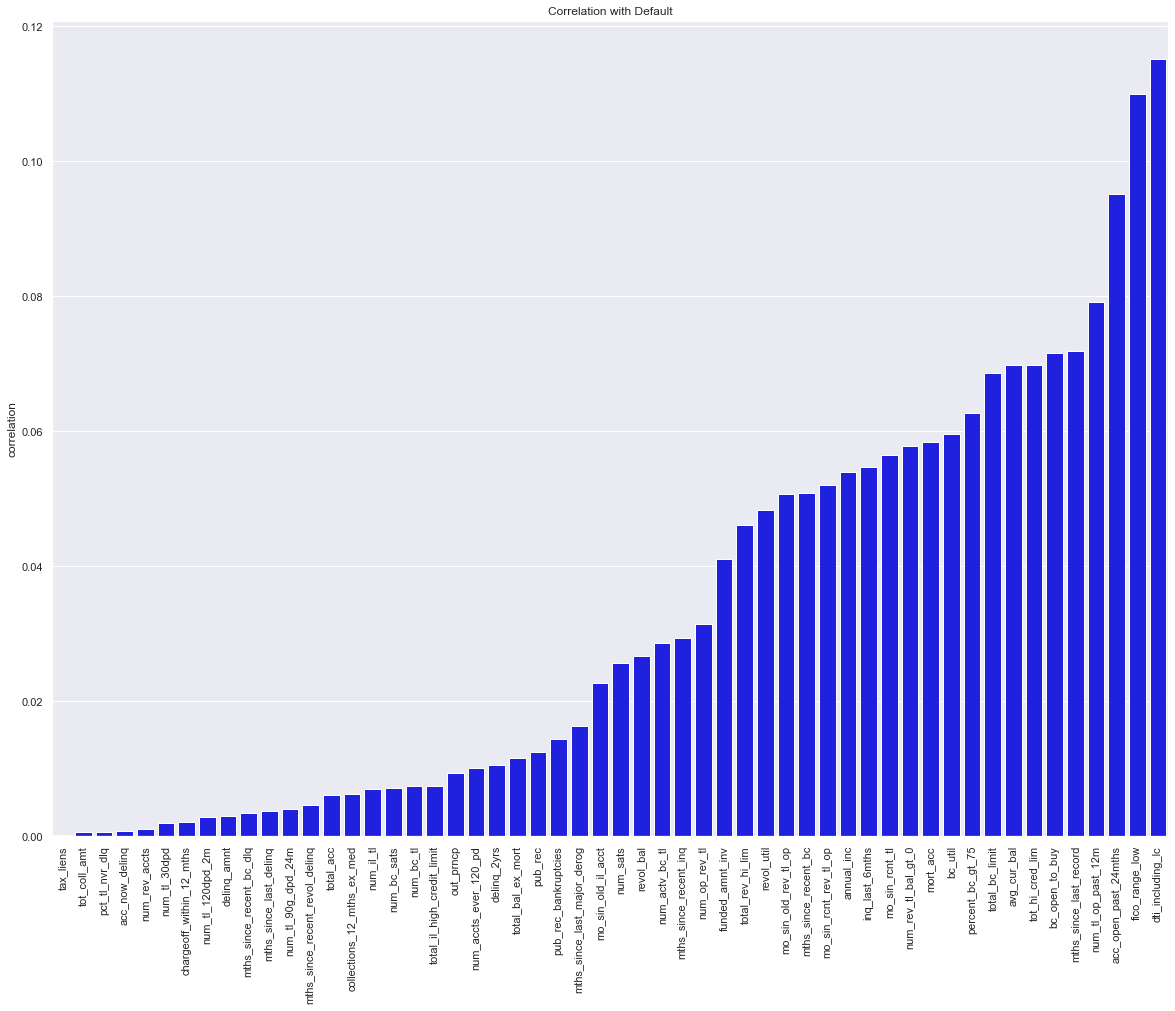

In [22]:
sns.set(font_scale=1)
plt.figure(figsize=(20,15))
small_corr = numcorr['default'].abs().sort_values(ascending=True).to_frame()
small_corr = small_corr.drop('default')
#ax = sns.barplot(x="day", y="total_bill", hue="sex", data=small_corr)
small_corr['items'] = small_corr.index
ax = sns.barplot(x="items", y="default", data=small_corr, color="blue")
ax.set(xlabel='', ylabel='correlation', title='Correlation with Default')
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
''

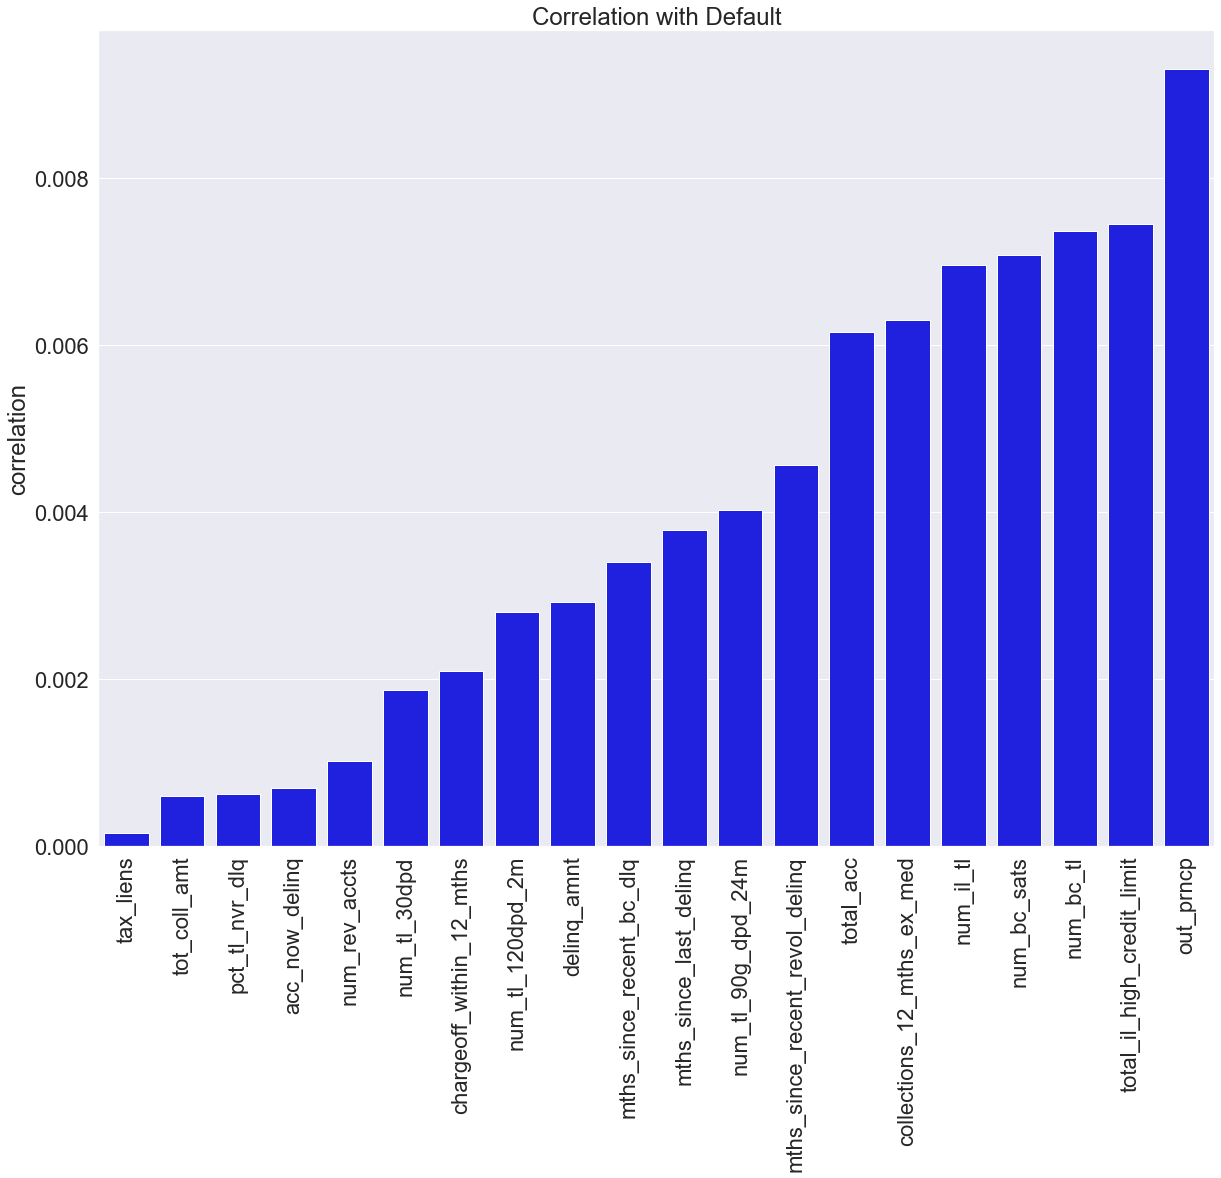

In [23]:
sns.set(font_scale=2)
plt.figure(figsize=(20,15))
small_corr = numcorr['default'].abs().sort_values(ascending=True).to_frame()
small_corr = small_corr[small_corr['default'] < 0.01]
#ax = sns.barplot(x="day", y="total_bill", hue="sex", data=small_corr)
small_corr['items'] = small_corr.index
ax = sns.barplot(x="items", y="default", data=small_corr, color="blue")
ax.set(xlabel='', ylabel='correlation', title='Correlation with Default')
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
lc.drop(small_corr['items'].to_numpy(), axis=1, inplace=True)

In [24]:
full_x = lc.drop(['default'], axis=1)
y = lc.default
obj_features = full_x.dtypes[full_x.dtypes == object].index.to_numpy()

for feature in obj_features:
    print(datetime.now())
    print(f'working on feature: {feature}')
    dummyZoning = pd.get_dummies(full_x[feature])
    dummyZoning = dummyZoning.add_prefix(feature + " ")
    full_x = full_x.join(dummyZoning)
    full_x.drop([feature], axis=1, inplace=True)

2020-04-21 17:29:55.821837
working on feature: term
2020-04-21 17:29:56.279519
working on feature: emp_title
2020-04-21 17:29:56.701611
working on feature: emp_length
2020-04-21 17:29:57.116873
working on feature: home_ownership
2020-04-21 17:29:57.485171
working on feature: verification_status
2020-04-21 17:29:57.844216
working on feature: issue_d
2020-04-21 17:29:58.198864
working on feature: purpose
2020-04-21 17:29:58.573271
working on feature: title
2020-04-21 17:29:58.920665
working on feature: zip_code
2020-04-21 17:30:01.376623
working on feature: addr_state
2020-04-21 17:30:02.416403
working on feature: initial_list_status
2020-04-21 17:30:03.267696
working on feature: earliest_cr_line_month
2020-04-21 17:30:04.067700
working on feature: earliest_cr_line_year
2020-04-21 17:30:04.919234
working on feature: last_credit_pull_d_month
2020-04-21 17:30:05.702882
working on feature: last_credit_pull_d_year


In [25]:
def log_regression(X_train, y_train, X_test, y_test):
    reg = linear_model.LogisticRegression(solver='lbfgs', fit_intercept=False) 
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print("Logistic Regression model accuracy(in %):",  
    metrics.accuracy_score(y_test, y_pred)*100)
    print("Logistic Regression R^2:",  
    r2_score(y_test, y_pred))
    print("Logistic Regression F1:",  
    f1_score(y_test, y_pred, average='weighted'))
    coef_pd = pd.DataFrame([reg.coef_[0]], columns=full_x.columns).transpose().rename(columns={0: "coef"})
    print(coef_pd.abs().head(15).sort_values(by=['coef'], ascending=False))

In [26]:
X = full_x.values

y = lc.default.values
# there might be a unique or scramble option i should use.
kf = KFold(n_splits=4, shuffle=True)
kf.get_n_splits(X)

print(kf)

for train_index, test_index in kf.split(X):
    print("=========")
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    log_regression(X_train, y_train, X_test, y_test)

KFold(n_splits=4, random_state=None, shuffle=True)
TRAIN: [     0      2      3 ... 235602 235603 235605] TEST: [     1      8      9 ... 235601 235604 235606]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic Regression model accuracy(in %): 82.4623951648501
Logistic Regression R^2: -0.21267396854154663
Logistic Regression F1: 0.7453966464255669
                                     coef
fico_range_low               1.890761e-03
bc_util                      1.656892e-04
mths_since_last_record       1.644578e-04
revol_util                   1.417894e-04
mths_since_last_major_derog  1.108907e-04
funded_amnt_inv              4.174978e-05
avg_cur_bal                  1.615924e-05
annual_inc                   5.267760e-06
bc_open_to_buy               5.169486e-06
revol_bal                    3.117328e-06
total_rev_hi_lim             2.177660e-06
acc_open_past_24mths         1.055499e-06
pub_rec                      7.770250e-07
delinq_2yrs                  4.290901e-07
inq_last_6mths               3.698301e-07
TRAIN: [     1      3      4 ... 235602 235604 235606] TEST: [     0      2      7 ... 235591 235603 235605]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Logistic Regression model accuracy(in %): 82.40127669688636
Logistic Regression R^2: -0.213573430031317
Logistic Regression F1: 0.7445090872428891
                                     coef
fico_range_low               1.910267e-03
bc_util                      1.687581e-04
mths_since_last_record       1.670073e-04
revol_util                   1.448233e-04
mths_since_last_major_derog  1.135695e-04
funded_amnt_inv              4.184563e-05
avg_cur_bal                  1.655694e-05
revol_bal                    6.200773e-06
annual_inc                   5.007978e-06
total_rev_hi_lim             4.688954e-06
bc_open_to_buy               2.514002e-06
acc_open_past_24mths         1.181105e-06
pub_rec                      7.717257e-07
delinq_2yrs                  3.991869e-07
inq_last_6mths               3.950571e-07
TRAIN: [     0      1      2 ... 235604 235605 235606] TEST: [     3      6     12 ... 235593 235597 235598]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Logistic Regression model accuracy(in %): 82.10756850361618
Logistic Regression R^2: -0.2179145214316729
Logistic Regression F1: 0.7404033628006133
                                     coef
fico_range_low               1.933824e-03
bc_util                      1.710597e-04
mths_since_last_record       1.693311e-04
revol_util                   1.453084e-04
mths_since_last_major_derog  1.148022e-04
funded_amnt_inv              4.230006e-05
avg_cur_bal                  1.429435e-05
annual_inc                   5.057126e-06
revol_bal                    4.650088e-06
total_rev_hi_lim             2.867843e-06
acc_open_past_24mths         1.599082e-06
pub_rec                      7.844382e-07
delinq_2yrs                  4.053394e-07
inq_last_6mths               2.268100e-07
bc_open_to_buy               1.703316e-07
TRAIN: [     0      1      2 ... 235604 235605 235606] TEST: [     4      5     13 ... 235596 235600 235602]
Logistic Regression model accuracy(in %): 82.22780597952497
Logistic Re

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
def print_error_message(y_actual, y_predicted, data_prefix, model_name):
    error = 0
    for i in range(len(y_actual)):
        error += (abs(y_predicted[i]-y_actual[i])/y_actual[i])
    error_percent = error/len(y_actual) * 100
    print(f'{data_prefix} error = {round(error_percent, 2)}% in {model_name}')

In [28]:
def ridge_regression(X_train, y_train, X_test, y_test):
    print("starting regression")
    ridge_reg = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1])

    ridge_reg.fit(X_train, y_train)
    ridge_ytrain = ridge_reg.predict(X_train)
    y_pred = ridge_reg.predict(X_test)

    print("Logistic Regression model accuracy(in %):",  
    metrics.accuracy_score(y_test, y_pred)*100)
    print("Logistic Regression R^2:",  
    r2_score(y_test, y_pred))
    print("Logistic Regression F1:",  
    f1_score(y_test, y_pred, average='weighted'))

In [29]:
X = full_x.values
#X = StandardScaler().fit_transform(X)

y = lc.default.values
# there might be a unique or scramble option i should use.
kf = KFold(n_splits=4, shuffle=True)
kf.get_n_splits(X)

print(kf)

for train_index, test_index in kf.split(X):
    print("=========")
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ridge_regression(X_train, y_train, X_test, y_test)

KFold(n_splits=4, random_state=None, shuffle=True)
TRAIN: [     0      1      2 ... 235602 235603 235604] TEST: [     4      9     17 ... 235600 235605 235606]
starting regression
Logistic Regression model accuracy(in %): 82.31129673016197
Logistic Regression R^2: -0.20646604925165635
Logistic Regression F1: 0.8077414514756119
TRAIN: [     2      3      4 ... 235604 235605 235606] TEST: [     0      1      7 ... 235597 235601 235602]
starting regression
Logistic Regression model accuracy(in %): 87.10570099487283
Logistic Regression R^2: 0.11298604744432317
Logistic Regression F1: 0.854606346317812
TRAIN: [     0      1      3 ... 235603 235605 235606] TEST: [     2      5      6 ... 235595 235599 235604]
starting regression
Logistic Regression model accuracy(in %): 87.07514176089097
Logistic Regression R^2: 0.11449159299951794
Logistic Regression F1: 0.8530077846592127
TRAIN: [     0      1      2 ... 235604 235605 235606] TEST: [     3      8     11 ... 235583 235596 235603]
starting 

In [30]:
def lasso_regression(X_train, y_train, X_test, y_test):
    print("starting regression")
    lasso_reg = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1])

    lasso_reg.fit(X_train, y_train)
    lasso_ytrain = lasso_reg.predict(X_train)
    y_pred = np.absolute(lasso_reg.predict(X_test).round())

    print("Logistic Regression model accuracy(in %):",  
    metrics.accuracy_score(y_test, y_pred)*100)
    print("Logistic Regression R^2:",  
    r2_score(y_test, y_pred))
    print("Logistic Regression F1:",  
    f1_score(y_test, y_pred, average='weighted'))

In [31]:
X = full_x.values
#X = StandardScaler().fit_transform(X)

y = lc.default.values
# there might be a unique or scramble option i should use.
kf = KFold(n_splits=4, shuffle=True)
kf.get_n_splits(X)

print(kf)

for train_index, test_index in kf.split(X):
    print("=========")
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lasso_regression(X_train, y_train, X_test, y_test)

KFold(n_splits=4, random_state=None, shuffle=True)
TRAIN: [     0      1      5 ... 235604 235605 235606] TEST: [     2      3      4 ... 235593 235599 235602]
starting regression


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Logistic Regression model accuracy(in %): 87.25340395911854
Logistic Regression R^2: 0.12179292712007606
Logistic Regression F1: 0.853962009875438
TRAIN: [     0      1      2 ... 235603 235604 235606] TEST: [    12     22     25 ... 235595 235596 235605]


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


starting regression


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Logistic Regression model accuracy(in %): 86.9070659739907
Logistic Regression R^2: 0.100137329167579
Logistic Regression F1: 0.8495056675333225
TRAIN: [     0      2      3 ... 235603 235604 235605] TEST: [     1      7     14 ... 235600 235601 235606]
starting regression


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Logistic Regression model accuracy(in %): 87.17530813894265
Logistic Regression R^2: 0.11643854549293797
Logistic Regression F1: 0.8531448279897339
TRAIN: [     1      2      3 ... 235602 235605 235606] TEST: [     0      5      6 ... 235594 235603 235604]
starting regression


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Logistic Regression model accuracy(in %): 87.09359773178723
Logistic Regression R^2: 0.11965910834237792
Logistic Regression F1: 0.8519504062427835


# New dependent variable

In [87]:
lc2 = pd.read_csv("~/Projects/dsa601/data/lendingclub_2014_ng_spelling.csv", index_col=0)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (16,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [132]:
lc.head()

,funded_amnt_inv,term,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,title,zip_code,addr_state,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_record,pub_rec,revol_bal,revol_util,initial_list_status,mths_since_last_major_derog,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_sats,num_tl_op_past_12m,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,earliest_cr_line_month,earliest_cr_line_year,last_credit_pull_d_month,last_credit_pull_d_year,default,dti_including_lc,loan_status,adandond_princ
0,10400,36 months,other,8 years,MORTGAGE,58000.0,Not Verified,December,credit_card,Credit card refinancing,937xx,CA,0,710,2,72.537032,0,6133,31.6,w,59.000000,19400,7,9536.0,7599.0,41.5,76.0,290,1,1,1,5.0,1.0,4,6,14,9,17,4,14.3,0,179407,15030,13000,September,1989,February,2017,1,0.215630,Charged Off,5182.25
1,15000,60 months,other,10+ years,RENT,78000.0,Source Verified,December,debt_consolidation,Debt consolidation,235xx,VA,0,750,0,70.283257,0,138008,29.0,w,42.318509,184500,5,29828.0,9525.0,4.7,103.0,244,1,1,0,47.0,0.0,0,1,5,4,6,4,0.0,0,196500,149140,10000,August,1994,November,2019,0,0.172091,Fully Paid,0.00
2,9600,36 months,other,10+ years,RENT,69000.0,Source Verified,December,debt_consolidation,Debt consolidation,077xx,NJ,0,680,0,70.283257,0,16388,59.4,f,42.318509,27600,8,3214.0,6494.0,69.2,183.0,265,23,3,0,24.0,17.0,0,4,8,7,12,3,60.0,0,52490,38566,21100,November,1992,July,2019,0,0.314888,Fully Paid,0.00
3,12800,60 months,other,10+ years,MORTGAGE,125000.0,Verified,December,car,Car financing,953xx,CA,1,665,0,70.283257,0,5753,100.9,w,36.000000,5700,2,32727.0,0.0,103.2,16.0,170,21,16,5,21.0,1.0,1,3,5,5,8,0,100.0,0,368700,18007,4400,October,2000,September,2019,0,0.113732,Fully Paid,0.00
4,21425,60 months,other,6 years,RENT,63800.0,Source Verified,December,credit_card,Credit card refinancing,658xx,MO,0,685,0,70.283257,0,16374,76.2,w,74.000000,21500,4,4232.0,324.0,97.8,135.0,136,7,7,0,7.0,7.0,1,3,5,4,10,2,100.0,0,57073,42315,15000,August,2003,April,2018,0,0.282021,Fully Paid,0.00


In [93]:
# lc = lc.drop(['adandond_princ', 'percent_of_principal'], axis=1)
lc = lc.drop(['total_rec_prncp'], axis=1)

In [95]:
lc['adandond_princ'] = lc2.funded_amnt - lc2.total_rec_prncp
lc['loan_status'] = lc2.loan_status

In [96]:
lc_final = lc.loc[lc['loan_status'].isin(['Charged Off', 'Fully Paid'])].copy()

lc_final['default'] = 0
lc_final.loc[lc_final['loan_status'] == 'Charged Off', 'default'] = 1

lc_final = lc_final.drop(['loan_status'], axis=1)

In [103]:
lc_final = lc_final[lc_final['default'] == 1]

In [104]:
full_x = lc_final.drop(['adandond_princ'], axis=1)
y = lc_final.adandond_princ
obj_features = full_x.dtypes[full_x.dtypes == object].index.to_numpy()

for feature in obj_features:
    print(datetime.now())
    print(f'working on feature: {feature}')
    dummyZoning = pd.get_dummies(full_x[feature])
    dummyZoning = dummyZoning.add_prefix(feature + " ")
    full_x = full_x.join(dummyZoning)
    full_x.drop([feature], axis=1, inplace=True)

2020-04-21 22:54:14.390747
working on feature: term
2020-04-21 22:54:14.499339
working on feature: emp_title
2020-04-21 22:54:14.581882
working on feature: emp_length
2020-04-21 22:54:14.661527
working on feature: home_ownership
2020-04-21 22:54:14.736285
working on feature: verification_status
2020-04-21 22:54:14.809477
working on feature: issue_d
2020-04-21 22:54:14.883175
working on feature: purpose
2020-04-21 22:54:14.954446
working on feature: title
2020-04-21 22:54:15.016052
working on feature: zip_code
2020-04-21 22:54:15.341066
working on feature: addr_state
2020-04-21 22:54:15.508723
working on feature: initial_list_status
2020-04-21 22:54:15.672502
working on feature: earliest_cr_line_month
2020-04-21 22:54:15.834133
working on feature: earliest_cr_line_year
2020-04-21 22:54:15.991138
working on feature: last_credit_pull_d_month
2020-04-21 22:54:16.139838
working on feature: last_credit_pull_d_year


In [110]:
def lasso_regression(X_train, y_train, X_test, y_test):
    print("starting regression")
    lasso_reg = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100])

    lasso_reg.fit(X_train, y_train)
    lasso_ytrain = lasso_reg.predict(X_train)
    y_pred = lasso_reg.predict(X_test)

    # print("Logistic Regression model accuracy(in %):",  
    # metrics.accuracy_score(y_test, y_pred)*100)
    print("Logistic Regression R^2:",  
    r2_score(y_test, y_pred))

In [111]:
X = full_x.values
#X = StandardScaler().fit_transform(X)

y = lc_final.adandond_princ.values
# there might be a unique or scramble option i should use.
kf = KFold(n_splits=4, shuffle=True)
kf.get_n_splits(X)

print(kf)

for train_index, test_index in kf.split(X):
    print("=========")
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lasso_regression(X_train, y_train, X_test, y_test)
    break

KFold(n_splits=4, random_state=None, shuffle=True)
TRAIN: [    0     2     4 ... 41700 41701 41702] TEST: [    1     3    13 ... 41695 41698 41699]
starting regression


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85706959794.3944, tolerance: 103741114.31775402
  tol, rng, random, positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119703077391.82434, tolerance: 103741114.31775402
  tol, rng, random, positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

Logistic Regression R^2: 0.767099599330641


In [127]:
X = full_x.values
print("starting regression")
lasso_reg = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100])

lasso_reg.fit(X_train, y_train)
lasso_ytrain = lasso_reg.predict(X_train)
y_pred = lasso_reg.predict(X_test)
y_pred = list(map(lambda x: x if x > 0 else 0, y_pred))
print("Logistic Regression R^2:",  
r2_score(y_test, y_pred))

starting regression


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85706959794.3944, tolerance: 103741114.31775402
  tol, rng, random, positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119703077391.82434, tolerance: 103741114.31775402
  tol, rng, random, positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

Logistic Regression R^2: 0.7691676083207835


In [131]:
X = full_x.values
print("starting regression")
lasso_reg = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100])

lasso_reg.fit(X_train, y_train)
lasso_ytrain = lasso_reg.predict(X_train)
y_pred = lasso_reg.predict(X_test)
y_pred = list(map(lambda x: x if x > 0 else 0, y_pred))
print("Logistic Regression R^2:",  
r2_score(y_test, y_pred))

starting regression
Logistic Regression R^2: 0.7685582048678854


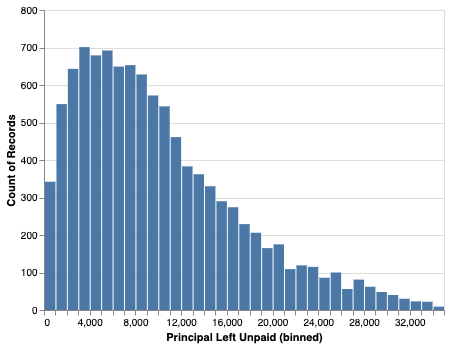

In [128]:
y_trains_graph = pd.DataFrame({'Principal Left Unpaid': y_test})
train_graph = alt.Chart(y_trains_graph).mark_bar().encode(
    alt.X("Principal Left Unpaid", bin=alt.Bin(maxbins=50)),
    y='count()',
)
train_graph

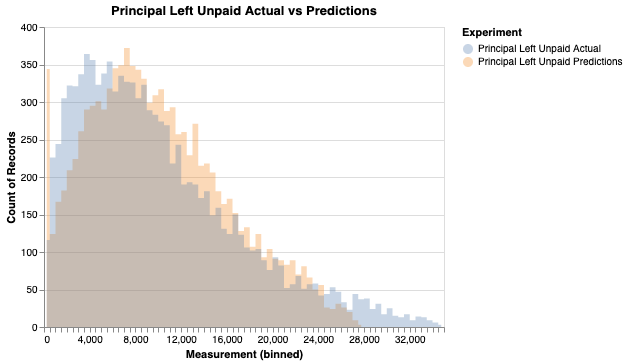

In [130]:
all_3 = pd.DataFrame({'Principal Left Unpaid Predictions': y_pred, 'Principal Left Unpaid Actual': y_test})

alt.Chart(all_3).transform_fold(
    ['Principal Left Unpaid Predictions', 'Principal Left Unpaid Actual'],
    as_=['Experiment', 'Measurement']
).mark_area(
    opacity=0.3,
    interpolate='step'
).encode(
    alt.X('Measurement:Q', bin=alt.Bin(maxbins=100)),
    alt.Y('count()', stack=None),
    alt.Color('Experiment:N')
).properties(
  title='Principal Left Unpaid Actual vs Predictions'
)

In [124]:
for i in y_pred:
    

array([ 7036.18323785, 16785.7321094 , 12072.3913994 , ...,
        6864.55469214,  1323.67307341,  7874.67452163])

In [126]:
list(map(lambda x: x if x > 0 else 0, y_pred))

[7036.183237848889,
 16785.7321093964,
 12072.391399398392,
 1205.094580792139,
 7840.454081682771,
 1435.499692503232,
 5019.602752656852,
 10850.38263307856,
 10040.033094009867,
 16855.337696311362,
 8858.121576698808,
 5434.8145490930365,
 11025.785442961058,
 19201.945271822347,
 13588.326108576763,
 12543.1799635851,
 18129.951092274874,
 9723.917775551083,
 3348.45176217714,
 7730.670584484182,
 8055.287002281587,
 14227.915358938193,
 21705.680436751645,
 7047.9580950190075,
 9912.269750265883,
 6285.028028706206,
 20558.779111839045,
 7697.516652725957,
 9862.08673261529,
 8386.509065616408,
 800.8713366643044,
 17280.3747270367,
 17515.800447373887,
 3163.278440597731,
 15079.019048905217,
 1197.2843556408443,
 6284.371631368045,
 11911.335462456116,
 2717.163552288038,
 1792.8081965226206,
 8307.840068919106,
 21320.263187589662,
 2608.701534234122,
 12900.51013191205,
 8159.239304446713,
 17847.473938272728,
 8339.44414353745,
 3782.971671431308,
 5340.2335035055285,
 2283.